In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.interpolate import interp1d
import seaborn as sns
from astropy.cosmology import WMAP9 as cosmo
import matplotlib.ticker as ticker
from scipy import constants as sc


import window_function_2
import pspec_copy
import make_universe_copy
import cross_pspec

import CII_foregrounds
from CCAT_p import CCAT_p


plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize']=24
plt.rcParams['xtick.labelsize']=24

%load_ext autoreload
%autoreload 2

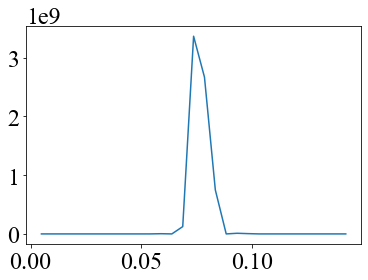

In [6]:
CII_field = np.loadtxt("CII_data.txt").reshape(50,50)

Lx,Ly = 325,325
nbins = 30

power_spec_CII = pspec_copy.Power_Spectrum(CII_field,Ly,Lx,nbins,0.15) #100 Mpc by 100M
p_CII_true = power_spec_CII.compute_2D_pspec()

plt.plot(p_CII_true[0],p_CII_true[1])

# CCAT-P No Foregrounds

In [7]:
RA = np.linspace(0,0.0349066,50) #rads (2 deg by 2 deg) 
DEC = np.linspace(0,0.0349066,50) #rads (2 deg by 2 deg) 

delta_RA = (RA[1]-RA[0])
delta_DEC = (DEC[1]-DEC[0])
omega_pix = np.abs((RA[1]-RA[0])*(DEC[1]-DEC[0])) #in sr




noisy_convolve = CCAT_p(CII_field,RA,DEC,200.36,6,True, 0.86e6, 3*(60*60), 0.75) 

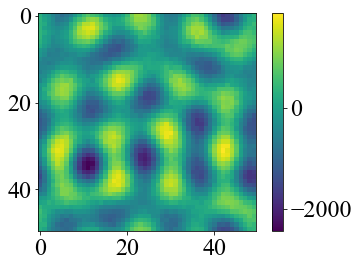

In [356]:
plt.imshow(noisy_convolve, interpolation = 'none')
plt.colorbar()

In [357]:
CII_CCAT = open("CII_CCAT.txt", "w")

for row in noisy_convolve:
    np.savetxt(CII_CCAT, row)

CII_CCAT.close()

In [285]:
Lx = 325.5
Ly = 325.5
nbins = 30
npix_row, npix_col = 50,50


In [261]:
#ensemble average Noise error bars.
# same universe, diff noise each time 

nreals = 2000

pspecs_ccat_noFG = []
kmodes = []

for i in range(nreals):
    noisy_convolve = CCAT_p(CII_field,RA,DEC,200.36,6,True, 0.86e6, 3*(60*60), 0.75) 
    power_spec_CII = pspec_copy.Power_Spectrum(noisy_convolve,Ly,Lx,nbins,0.15) #100 Mpc by 100M
    p_CII_ccat = power_spec_CII.compute_2D_pspec()
    pspecs_ccat_noFG.append(p_CII_ccat[1])
    
    if i == 0:
        kmodes.append(p_CII_ccat[0])
    else:
        pass
    

In [262]:
#COMPUTE AVERAGE AND NOISE ERROR BARS

pspecs_ccat_noFG = np.asarray(pspecs_ccat_noFG)

ave_ccat_spec_noFG = np.sum(pspecs_ccat_noFG,axis = 0)/nreals

sigma_ccat_noFG = []

for i in range(nbins-1):
    k_dist = pspecs_ccat_noFG[:,i]
    sigma_ccat_noFG.append(np.std(k_dist))

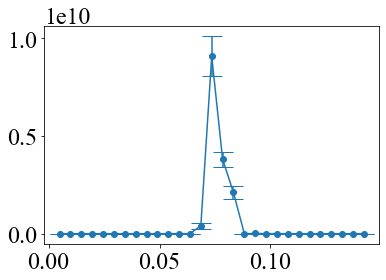

In [263]:
plt.errorbar(kmodes[0],ave_ccat_spec_noFG, xerr = None, yerr = sigma_ccat_noFG*(np.ones(29)*30), markersize=8, capsize=10)
plt.scatter(kmodes[0],ave_ccat_spec_noFG)



In [363]:
data_ccat = [kmodes[0],ave_ccat_spec_noFG,sigma_ccat_noFG]

CCAT = open("data_ccat.txt", "w")

for row in data_ccat:
    np.savetxt(CCAT, row)

CCAT.close()

# [CII] with FG  - 1 obs

In [8]:
delta_channel = 2.5/2
mid_freq = 200


cii_fg = CII_foregrounds.CII_fg(mid_freq - delta_channel,mid_freq + delta_channel,omega_pix,2500)
fgs = cii_fg.intensity()
fg_tot = np.reshape(np.sum(cii_fg.I, axis =0) ,(50,50))

In [11]:
cii_fg.delta_freq

2.5

In [359]:

FG_CII = open("FG_CII.txt", "w")

for row in fg_tot:
    np.savetxt(FG_CII, row)

FG_CII.close()

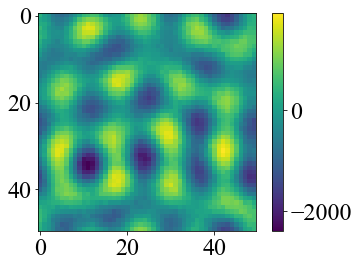

In [287]:
plt.imshow((noisy_convolve+fg_tot)-fg_tot)
plt.colorbar()

In [352]:
noisy_convolve_FG = CCAT_p(CII_field+fg_tot,RA,DEC,200.36,6,True, 860000, 60*60, 0.75) 
power_spec_CII_FG = pspec_copy.Power_Spectrum(noisy_convolve_FG,Ly,Lx,nbins,0.15) #100 Mpc by 100M
p_CII_FG = power_spec_CII_FG.compute_2D_pspec()

In [353]:
CII_CCAT_FG = open("CII_CCAT_FG.txt", "w")

for row in noisy_convolve_FG:
    np.savetxt(CII_CCAT_FG, row)

CII_CCAT_FG.close()

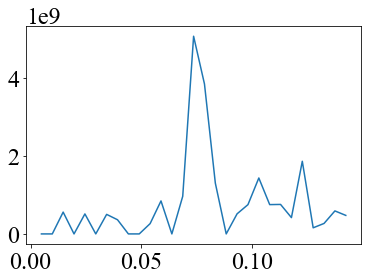

In [354]:
plt.plot(p_CII_FG[0],p_CII_FG[1])

In [364]:
#ensemble average Noise error bars.
# same universe, diff noise each time 


pspecs_ccat_FG_null = []
kmodes = []

for i in range(nreals):
    noisy_convolve_FG = CCAT_p(fg_tot,RA,DEC,200.36,6,True, 0.86e6, 3*(60*60), 0.75) 
    power_spec_CII_FG = pspec_copy.Power_Spectrum(noisy_convolve_FG,Ly,Lx,nbins,0.15) #100 Mpc by 100M
    p_CII_FG = power_spec_CII_FG.compute_2D_pspec()
    pspecs_ccat_FG_null.append(p_CII_FG[1])
    
    if i == 0:
        kmodes.append(p_CII_FG[0])
    else:
        pass
    

In [365]:
#COMPUTE AVERAGE AND NOISE ERROR BARS

pspecs_ccat_FG_null = np.asarray(pspecs_ccat_FG_null)

ave_ccat_spec_FG_null = np.sum(pspecs_ccat_FG_null,axis = 0)/nreals

sigma_ccat_FG_null = []

for i in range(nbins-1):
    k_dist = pspecs_ccat_FG_null[:,i]
    sigma_ccat_FG_null.append(np.std(k_dist))

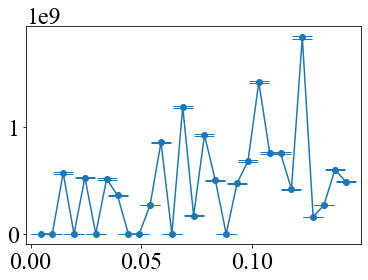

In [366]:
plt.errorbar(kmodes[0],ave_ccat_spec_FG_null , xerr = None, yerr = sigma_ccat_FG_null , markersize=8, capsize=10)
plt.scatter(kmodes[0],ave_ccat_spec_FG_null )

In [367]:
data_ccat_fg_null  = [ave_ccat_spec_FG_null ,sigma_ccat_FG_null ]

CCAT_1FG = open("data_ccat_fg_null .txt", "w")

for row in data_ccat_fg_null:
    np.savetxt(CCAT_1FG, row)

CCAT_1FG.close()

# [CII] with FG  - N obs

In [268]:
#here the errors are due to both cosmic variance and instrumental noise 

pspecs_ccat_Nobs = []
kmodes = []

def ps(x):
    mu, sigma = 0.08,0.005
    return  np.exp( - (x - mu)**2 / (2 * sigma**2))

for i in range(nreals):
    

    make_uni = make_universe_copy.universe(ps,npix_row,npix_col,Ly,Lx, mean = None) #100 Mpc by 100Mpc
    CII_field = make_uni.make_2D_universe()*540*105
    
    noisy_convolve_FG = CCAT_p(CII_field+fg_tot,RA,DEC,200.36,6,True, 0.86e6, 3*(60*60), 0.75) 
    power_spec_CII_FG = pspec_copy.Power_Spectrum(noisy_convolve_FG,Ly,Lx,nbins,0.15) #100 Mpc by 100M
    p_CII_FG = power_spec_CII_FG.compute_2D_pspec()
    pspecs_ccat_Nobs.append(p_CII_FG[1])
    
    if i == 0:
        kmodes.append(p_CII_FG[0])
    else:
        pass
    

In [269]:
#COMPUTE AVERAGE AND NOISE ERROR BARS

pspecs_ccat_Nobs = np.asarray(pspecs_ccat_Nobs)

ave_ccat_spec_Nobs = np.sum(pspecs_ccat_Nobs,axis = 0)/nreals

sigma_ccat_Nobs = []

for i in range(nbins-1):
    k_dist = pspecs_ccat_Nobs[:,i]
    sigma_ccat_Nobs.append(np.std(k_dist))

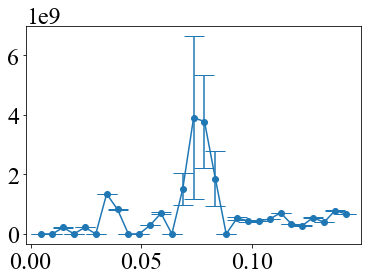

In [368]:
plt.errorbar(kmodes[0],ave_ccat_spec_Nobs, xerr = None, yerr = sigma_ccat_Nobs, markersize=8, capsize=10)
plt.scatter(kmodes[0],ave_ccat_spec_Nobs)

In [362]:
data_ccat_fg_Nobs = [ave_ccat_spec_Nobs,sigma_ccat_Nobs]

CCAT_NFG = open("data_ccat_fg_Nobs.txt", "w")

for row in data_ccat_fg_Nobs:
    np.savetxt(CCAT_NFG, row)

CCAT_NFG.close()